### 1. Import libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
#------------- Supress warnings ---------------
import warnings
warnings.filterwarnings("ignore")

### 2. Read datasets

In [41]:
df = pd.read_csv("dataset/train.csv")           # source train data
test = pd.read_csv("dataset/test.csv")          # source test data
test_set = pd.read_csv("dataset/test.csv")     

## 3. Preprocessing + EDA

### 3.1 Check for null values, missing values and describe data

In [4]:
# df.head(10)           # to check if dataset is correct
# df.describe()         # look for mean, min, max
# df.info()             # columns info 
# df.isnull().sum()     
# df.isna().sum()

# test.head(10)           # to check if dataset is correct
# test.describe()         # look for mean, min, max
# test.info()             # columns info 
# test.isnull().sum()     
# test.isna().sum()

In [42]:
# ------ Since winPlacePerc has only 1 missing value we replace it with mean ----------
df['winPlacePerc'].fillna(value=df.winPlacePerc.mean(), inplace=True)

### Feature Engineering + dropping

In [5]:
# # finding those wrong combinations of solo/duo and players count
# # solo can not have >1 player
# # duo can not have >2 players
# indexdrop = df[((df.matchType=='solo') & (df.groupId.value_counts()>1)) | ((df.matchType=='duo') & (df.groupId.value_counts()>2))]
# print(indexdrop)

# # *******OBSERVATION********* 
# # no mismatch found
# # ***************************

# # ------------------ Count of each groupId ------------------ 

# series = df.groupId.value_counts()
# count = 0
# for i in series:
#     if i>4:
#         count = count + 1;
# print(count)
# # ------------------ NOTE -----------------
# # 48412 groupIds have more than 4 players which is not possible
# # so we can remove them
# ******** Perform drop *********
# out_groupId = df.groupby('groupId').filter(lambda x : len(x)>4).groupId
# df.drop(out_groupId.index,inplace=True)

In [43]:
# -------------- create new column players count ------------------
df['players_count'] = df.groupby('matchId')['matchId'].transform('count')
test['players_count'] = test.groupby('matchId')['matchId'].transform('count')

# # -------------- new column headshot rate -------------------------
# df['headshot_rate'] = df.headshotKills/df.kills
# df.headshot_rate = df.headshot_rate.fillna(0)
# test['headshot_rate'] = test.headshotKills/df.kills
# test.headshot_rate = test.headshot_rate.fillna(0)

# # --------------- new column total distance -------------------
# df['distance'] = df.walkDistance+df.swimDistance+df.rideDistance
# test['distance'] = test.walkDistance+test.swimDistance+test.rideDistance
# df.drop(['walkDistance','swimDistance','rideDistance'],axis=1,inplace=True)
# test.drop(['walkDistance','swimDistance','rideDistance'],axis=1,inplace=True)

# # ---------------- new column aid ------------------
# df['aid'] = df.heals+df.boosts
# test['aid'] = test.heals+test.boosts
# df.drop(['heals','boosts'],axis=1,inplace=True)
# test.drop(['heals','boosts'],axis=1,inplace=True)

### 3.2 Dropping Id columns

In [44]:
# # ---- Id of the match, group and player is unique to the player and match so it should not influence winning place ---- #

df.drop(['matchId','groupId','Id'],axis=1,inplace=True)
test.drop(['matchId','groupId','Id'],axis=1,inplace=True)

### Dropping anomalies

In [13]:
# --------- headshot rate 100% with more than 10 kills is near to impossible -----------
head_kill_out = df[(df.headshot_rate==1) & (df.kills>=10)].index
df.drop(head_kill_out,inplace=True)

# ---------------- Kills without moving -------------
kill_no_move = df[(df.kills>0) & (df.distance==0)].index
df.drop(kill_no_move,inplace=True)

# ---------- killing over 500m is not possible ------------
# because even with 8x scope you can not see more than 500m
impossible_kill = df[df.longestKill>1000].index
df.drop(impossible_kill,inplace=True)

### Dealing with categorical data

### 3.3 Encoding match type
One-hot encoding is the representation of categorical variables as binary vectors. Label Encoding is converting labels/words into numeric form

We choose one-hot enconding because we do not want to assign weightage to any match type and treat all types equal for predicting result

In [45]:
# ----------- Since matchType is a category we are using one hot encoder -----------------

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# By specifying remainder='passthrough', all remaining columns that were not specified
# in transformers will be automatically passed through
transformer = make_column_transformer((OneHotEncoder(), ['matchType']),remainder='passthrough')

# transformed contains transformed columns, now convert it into dataframe and give columns default encoded names
transformed = transformer.fit_transform(df)              
final_df = pd.DataFrame(transformed, columns=transformer.get_feature_names())

transformed = transformer.fit_transform(test)
final_test = pd.DataFrame( transformed,columns=transformer.get_feature_names())

# since coulmn transformer made our dataframe lables type=object we convert it to float 
final_df = final_df.astype(float)
final_test = final_test.astype(float)

In [47]:
# final_test.headshot_rate.replace(final_test.headshot_rate.max(),0,inplace=True)

### 3.4 Feature Selection

#### 3.5 Mutual information gain

In [11]:
# Mutual information measures the uncertainty reduction between 2 variables
# or/and for 1 variable when the other variable is a known value. It is stated as 
# I(X ; Y) = H(X) – H(X | Y)
# Where the LHS of I(X ; Y) is the calculated value of mutual information or 
# gain ratio for Y and X the 2 variables, the entropy of X represented by H(X) and the conditional entropy represented by H(X | Y) for X when Y is given

In [51]:
from sklearn.feature_selection import mutual_info_regression

# Take 3 Lakh rows for sampling
one = final_df.sample(500000)       # 15 min

# Find mutual relationship between winPlacePerc and other columns
mutual_info = mutual_info_regression(one.drop('winPlacePerc',axis=1),one.winPlacePerc) 

In [52]:
mutual_info =  pd.Series(mutual_info)                           # make series of mutual_info
mutual_info.index = one.drop('winPlacePerc',axis=1).columns     # drop final label
mutual_info = mutual_info.sort_values(ascending=False)          # sort values in descending order

print(mutual_info)

maxPlace                              2.383306
numGroups                             1.197960
killPlace                             0.951188
walkDistance                          0.742779
weaponsAcquired                       0.323713
boosts                                0.322173
onehotencoder__x0_squad-fpp           0.269480
onehotencoder__x0_duo-fpp             0.236813
heals                                 0.198098
damageDealt                           0.163317
onehotencoder__x0_solo-fpp            0.159959
longestKill                           0.147384
kills                                 0.128329
rideDistance                          0.121461
DBNOs                                 0.112635
killStreaks                           0.102216
onehotencoder__x0_squad               0.075194
assists                               0.067226
rankPoints                            0.064652
onehotencoder__x0_duo                 0.060103
revives                               0.057010
matchDuration

### 3.6 Correlation matrix

In [14]:
# # Check correlation of winning place with features
# corr_feature = final_df.corr().winPlacePerc.abs()
# corr_feature.sort_values(ascending=False)

#### On our observation information through mutual info performed better than correlation 
![](2022-10-20-19-47-12.png)
![](2022-10-20-19-47-40.png)

### 3.5 Dropping less important features

In [53]:
# threshold set for info_gain > 0.05

futile_features = ['onehotencoder__x0_normal-duo-fpp',
                   'onehotencoder__x0_flarefpp',
                   'onehotencoder__x0_normal-squad',
                   'onehotencoder__x0_normal-solo',
                   'onehotencoder__x0_crashtpp',
                   'roadKills',
                   'onehotencoder__x0_crashfpp',
                   'onehotencoder__x0_normal-duo',
                   'onehotencoder__x0_flaretpp',
                   'onehotencoder__x0_normal-solo-fpp',
                   'onehotencoder__x0_normal-squad-fpp',
                   'vehicleDestroys',
                   'teamKills',
                   'killPoints',
                   'winPoints',
                   'matchDuration',
                   'onehotencoder__x0_solo',
                   'headshotKills',
                   'swimDistance',
                   'headshotKills']

# Drop features in both test and train data (18 columsn dropped)
final_df.drop(futile_features, axis=1, inplace=True)       
final_test.drop(futile_features, axis=1, inplace=True)

### 3.6 Outlier detection

C:\Users\Asus\AppData\Local\Temp\ipykernel_18024\41616203.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


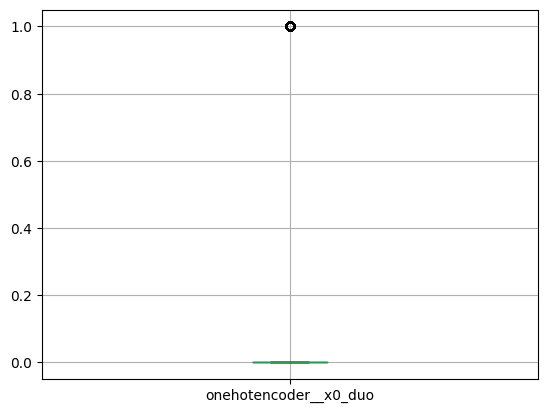

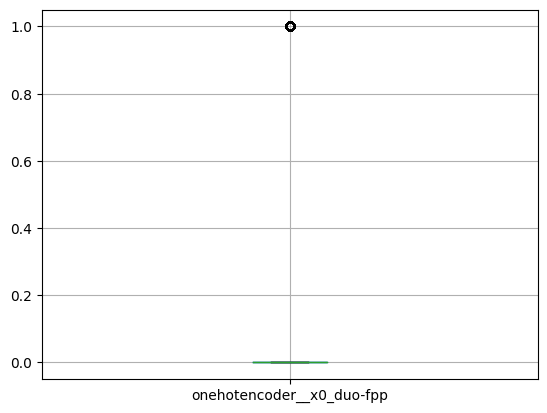

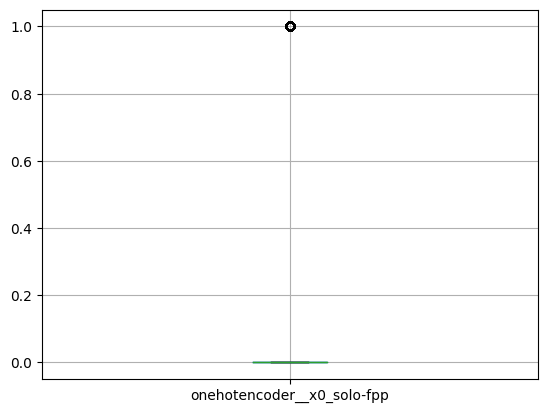

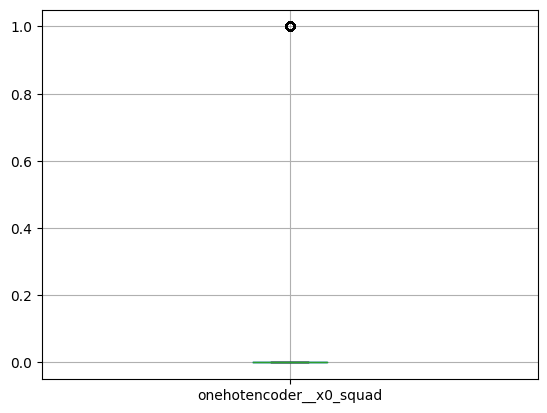

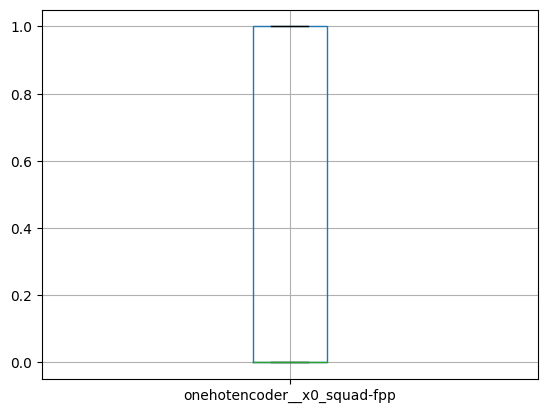

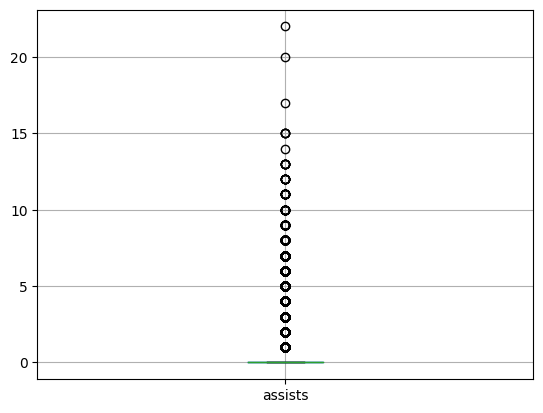

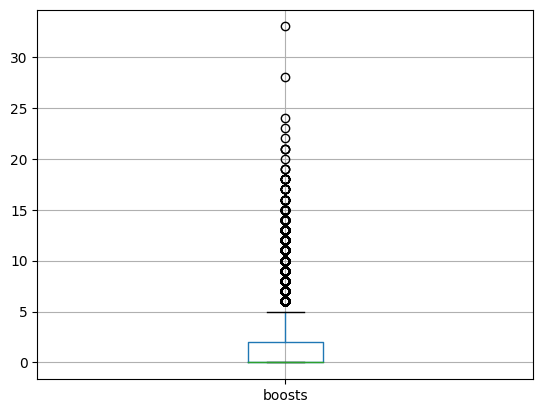

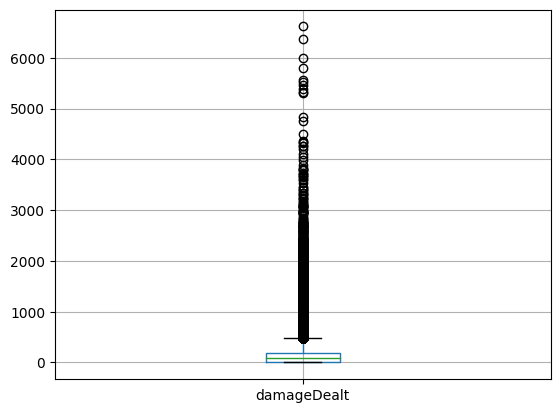

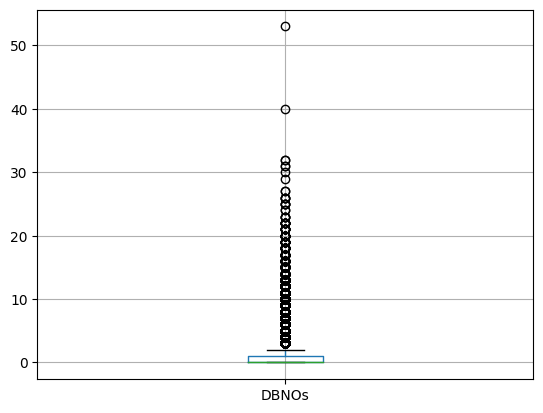

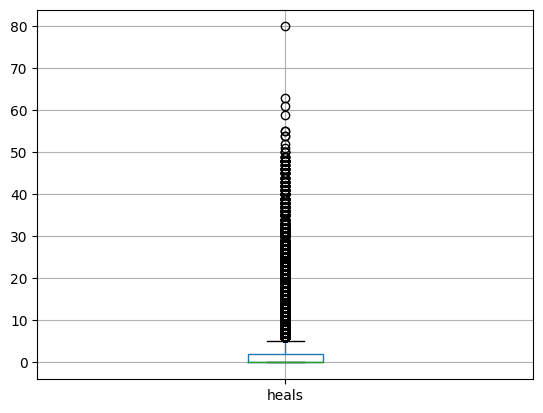

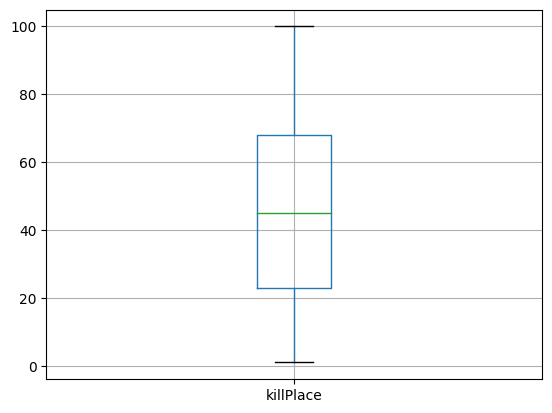

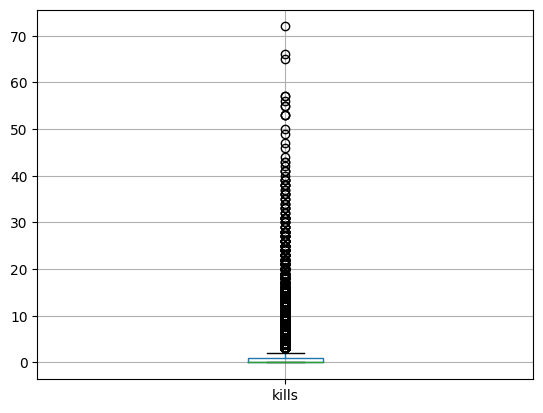

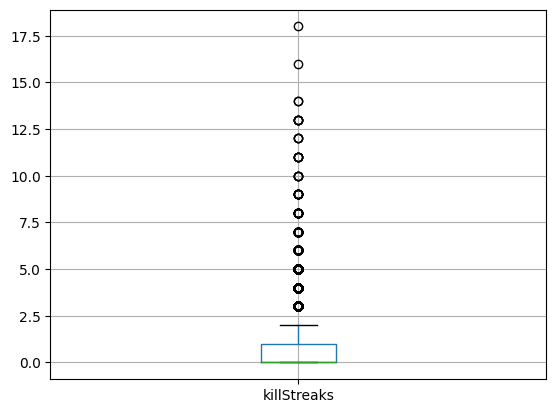

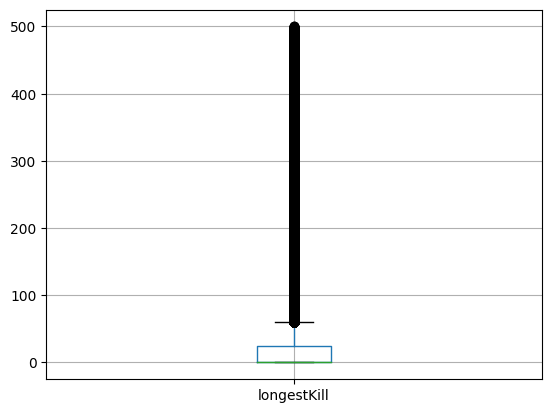

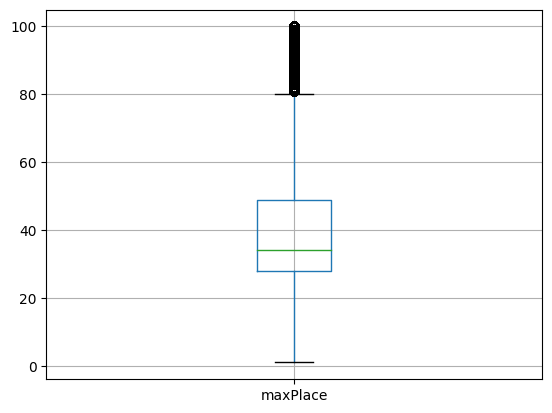

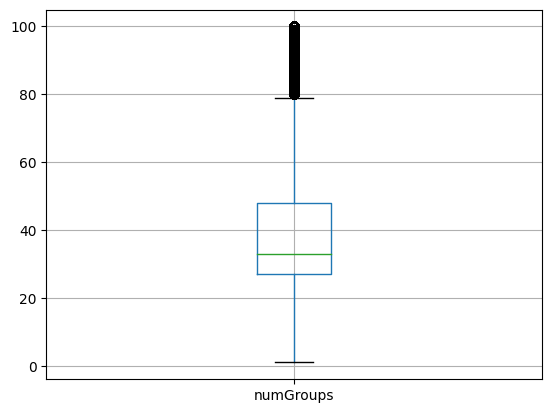

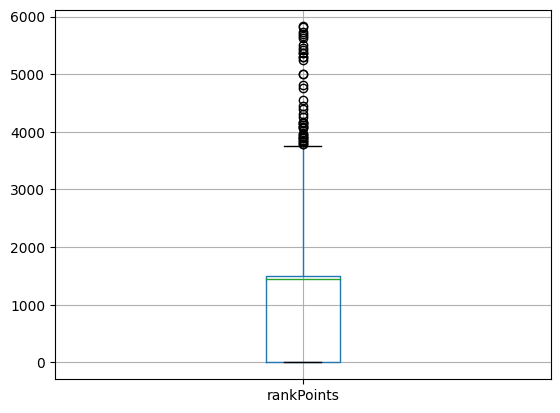

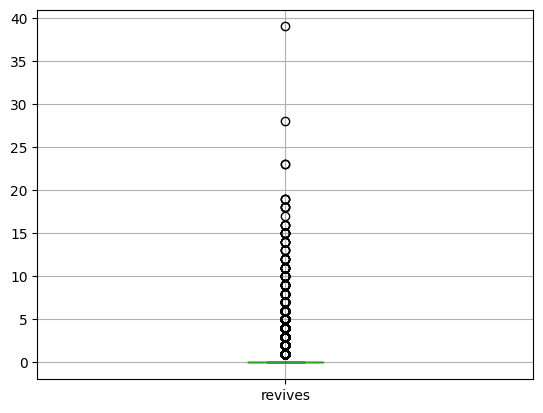

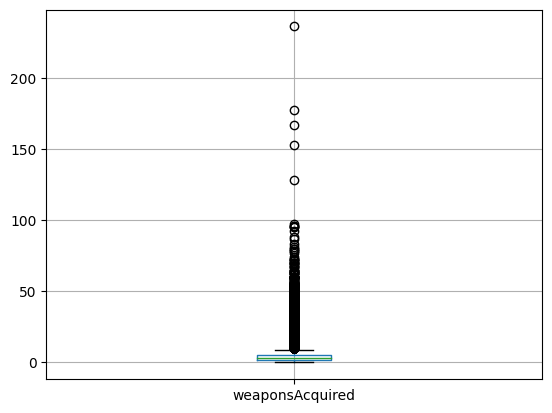

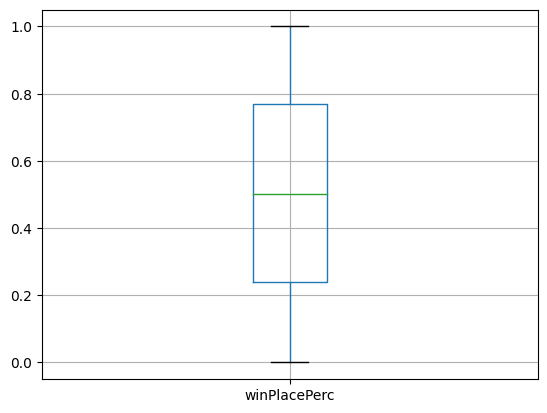

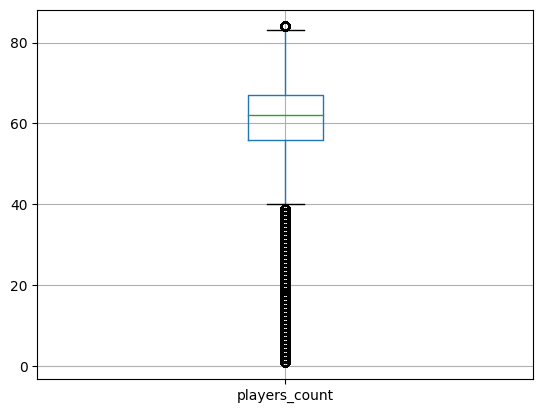

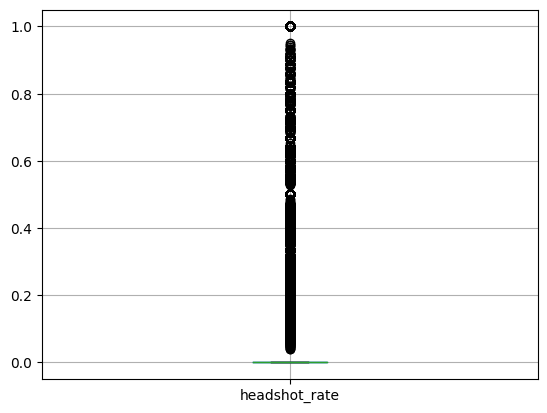

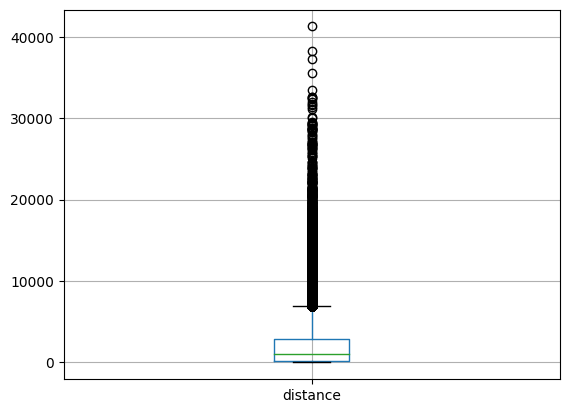

In [64]:
# # Boxplots for each feature
# for column in final_df:
#     plt.figure()
#     final_df.boxplot([column])

### 3.7 Outliers capping

In [55]:
# --------------- Set limits to outliers based on boxplot result ---------------

# Limits for features
out_assists = 15
out_damageDealt = 5000
out_DBNOs = 35
out_kills = 40
out_killStreaks = 15
# out_aid = 60
out_revives = 20
# out_distance = 35000
out_weaponsAcquired = 100

# Apply limits to training set
final_df.assists[final_df.assists>out_assists] = out_assists
final_df.damageDealt[final_df.damageDealt>out_damageDealt] = out_damageDealt
final_df.DBNOs[final_df.DBNOs>out_DBNOs] = out_DBNOs
final_df.kills[final_df.kills>out_kills] = out_kills
# final_df.aid[final_df.aid>out_aid] = out_aid
final_df.killStreaks[final_df.killStreaks>out_killStreaks] = out_killStreaks
final_df.revives[final_df.revives>out_revives] = out_revives
# final_df.distance[final_df.distance>out_distance] = out_distance
final_df.weaponsAcquired[final_df.weaponsAcquired>out_weaponsAcquired] = out_weaponsAcquired

# Apply limits to test set
final_test.assists[final_test.assists>out_assists] = out_assists
final_test.damageDealt[final_test.damageDealt>out_damageDealt] = out_damageDealt
final_test.DBNOs[final_test.DBNOs>out_DBNOs] = out_DBNOs
final_test.kills[final_test.kills>out_kills] = out_kills
# final_test.aid[final_test.aid>out_aid] = out_aid
final_test.killStreaks[final_test.killStreaks>out_killStreaks] = out_killStreaks
final_test.revives[final_test.revives>out_revives] = out_revives
# final_test.distance[final_test.distance>out_distance] = out_distance
final_test.weaponsAcquired[final_test.weaponsAcquired>out_weaponsAcquired] = out_weaponsAcquired

### Export Preprocessed data

In [20]:
# Export dataframe to .csv file

final_df.to_csv('dataset/final_df.csv',index = False)
final_test.to_csv('dataset/final_tet.csv',index=False)

## 4 Training the model

### 4.1 Train test split

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# # training on 5lakh samples because full size takes too long
# one = final_df.sample(500000)

# X = one.drop(['winPlacePerc'], axis=1)
# y = one.winPlacePerc

X = final_df.drop(['winPlacePerc'], axis=1)
y = final_df.winPlacePerc

# X = StandardScaler().fit_transform(X)        # only for linear models

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)   # 30% test, 70% train split

### 4.2 Models selections

#### 4.2.1 Linear regressor

In [52]:
# from sklearn.linear_model import LinearRegression

# reg = LinearRegression().fit(X_train, y_train)

# y_pred = reg.predict(X_test)
# y_test_perd = reg.predict(StandardScaler().fit_transform(final_test))

![](2022-10-20-19-28-36.png)

#### 4.2.1 Support Vector Regressor

In [18]:
# from sklearn.svm import SVR

# # # ----------- Linear kernel -----------------
# # reg = SVR(kernel='linear')
# # reg.fit(X_train,y_train)

# # y_pred = reg.predict(X_test)
# # y_test_perd = reg.predict(StandardScaler().fit_transform(final_test))
# # # MAE = 0.1012092367376948

# # ------------- RBF Kernel ------------------
# # rbf = SVR(kernel='rbf')
# # rbf.fit(X_train,y_train)

# # y_pred = rbf.predict(X_test)                                                    # 22 min (train+predict till here)
# # y_test_perd = rbf.predict(StandardScaler().fit_transform(final_test))           # 43 min (predict only)
# # # MAE = 0.07004152051683103

# #------------------ OBSERVATION : rbf kernel performs better -------------------

### 4.2.2 Elasstic Net regressor
![](2022-11-21-12-11-03.png)

In [28]:
# from sklearn.linear_model import ElasticNet
# from sklearn.model_selection import GridSearchCV

# parametersGrid = {
#     "alpha": [0.001,0.01,0.1],               # alpha shoul be small
#     "max_iter": [1000],                      # 1000 is ok
#     "l1_ratio": [0.01,0.1,0.3],              # 0.01 
# }
# eNet = ElasticNet(alpha=0.001,max_iter=1000,l1_ratio=0.01)
# grid = GridSearchCV(eNet, parametersGrid, scoring='r2',verbose=3)
# eNet.fit(X_train,y_train)

# y_pred = eNet.predict(X_test)
# y_test_perd = eNet.predict(StandardScaler().fit_transform(final_test))

![](2022-11-21-15-33-28.png)

#### 4.2.3 Ridge regressor

In [57]:
# from sklearn.linear_model import Ridge

# reg = Ridge(alpha=1)
# reg.fit(X_train,y_train)

# y_pred = reg.predict(X_test)
# y_test_perd = reg.predict(final_test)

![](2022-11-21-15-36-00.png)

#### 4.2.2 XG Boost
<!-- 
learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
max_depth: determines how deeply each tree is allowed to grow during any boosting round.
subsample: percentage of samples used per tree. Low value can lead to underfitting.
colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
n_estimators: number of trees you want to build.
objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.
XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.
gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
alpha: L1 regularization on leaf weights. A large value leads to more regularization.
lambda: L2 regularization on leaf weights and is smoother than L1 regularization. -->

In [73]:
# import xgboost as xgb

# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.2, alpha = 1, n_estimators = 200,max_depth=12,verbosity=2)
# xg_reg.fit(X_train,y_train)
# y_pred = xg_reg.predict(X_test)
# y_test_perd = xg_reg.predict(final_test)    #21 min

[10:33:03] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4196 extra nodes, 0 pruned nodes, max_depth=12
[10:33:09] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4220 extra nodes, 0 pruned nodes, max_depth=12
[10:33:15] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4770 extra nodes, 0 pruned nodes, max_depth=12
[10:33:20] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 3800 extra nodes, 0 pruned nodes, max_depth=12
[10:33:27] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4372 extra nodes, 0 pruned nodes, max_depth=12
[10:33:33] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 424

![](2022-10-20-19-29-09.png)

#### 4.2.3 Random forest
<!-- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html -->

In [34]:
# from sklearn.ensemble import RandomForestRegressor

# tree_reg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
#            max_features='auto',n_estimators=200, random_state=42)
# tree_reg.fit(X_train,y_train) 
# y_pred = tree_reg.predict(X_test)         # predcting for split test set
# y_test_perd = tree_reg.predict(test)      # predicting for test set

![](2022-10-20-19-30-38.png)

#### 4.2.4 MLP regressor


In [59]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV


# ----------- relu ---------
reg = MLPRegressor(random_state=7, max_iter=1000, activation="relu").fit(X_train, y_train)  
y_pred = reg.predict(X_test)            ##32min

# regr = MLPRegressor(random_state=7, max_iter=2000).fit(X_train, y_train)
# y_pred = regr.predict(X_test)
# y_test_perd = regr.predict(final_test)

# 8 min
# MAE 0.0645

![](2022-11-20-15-35-42.png)

### 4.2.5 LG Boost

In [30]:
import lightgbm as lgb

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.07,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 2,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 10000 # 32min
}

gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)])
        
# y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# y_test_perd = gbm.predict(final_test, num_iteration=gbm.best_iteration_)

# MAE = 0.06370080370165758

C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.787619
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.340159
[LightGBM] [Debug] init for col-wise cost 0.069540 seconds, init for row-wise cost 0.361002 seconds
[LightGBM] [Warning] Auto-choosing row-wi

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.07, max_bin=512, max_depth=8, metric=['l1', 'l2'],
              num_iterations=10000, num_leaves=128, objective='regression',
              task='train', verbose=2)

In [31]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
y_test_perd = gbm.predict(final_test, num_iteration=gbm.best_iteration_)  #53min

### 4.3 Check MAE 

In [60]:
import sklearn.metrics as metrics

metrics.mean_absolute_error(y_test,y_pred)
# 0.05609854569635893 best achieved result

0.07445803207976892

## 5. Post processing 

### 5.1 Capping winning percentage values

In [33]:
# ------- Since predicted winning percentage may not lie in range [0,1] we bring them in range --------- #

# For split test set
y_pred[y_pred>1] = 1
y_pred[y_pred<0] = 0

# For test set
y_test_perd[y_test_perd>1] = 1
y_test_perd[y_test_perd<0] = 0

### 5.2 Creating submission Dataset

In [35]:
sub = pd.DataFrame(test_set.Id)     # get 'Id' column from original source test set
sub["winPlacePerc"] = y_test_perd   # add column winPlacePerc
print(sub.shape)                    # check for correct shape
sub.head(10)                        # check if created right

(1334090, 2)


,Id,winPlacePerc
0,a5e44e9ccbd861,0.000000
1,ec09f9f5c29d75,0.959422
2,fe603d927d7792,0.000000
3,f7aa0b9da441b1,0.891594
4,bcd3f9cb689f6c,0.000000
5,0f40c22097835b,0.000000
6,3cfede1b53e459,0.432886
7,7f0dde8a1a3e72,0.670103
8,1eb46d6f0a48e9,0.062226
9,3bca380365ef78,0.474143


### 5.3 Submission dataset to csv file

In [36]:
# Export dataframe to .csv file
sub.to_csv('sub1.csv',index = False)

## 6 Confirm csv created correctly

In [37]:
mock = pd.read_csv("sub1.csv")
mock.shape

(1334090, 2)